In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,TimeDistributed, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as ef_preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import kagglehub
from glob import glob
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mo_preprocess_input
import random

c:\Users\user2\.conda\envs\tf-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [229]:
# # Download latest version
# path = kagglehub.dataset_download("adityajn105/flickr8k")

# print("Path to dataset files:", path)

In [ ]:
# !mkdir dataset
# !copy "C:\Users\user2\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\*" flickr\

In [ ]:
# image 데이터 추출
for file_name in glob('C:/Users/user2/Documents/folder/github/flickr/image/*.jpg')[:5]:
    print(file_name.split('\\')[1])
    # print(np.array(Image.open(file_name)))

1000268201_693b08cb0e.jpg
1001773457_577c3a7d70.jpg
1002674143_1b742ab4b8.jpg
1003163366_44323f5815.jpg
1007129816_e794419615.jpg


In [ ]:
# target 추출

with open('flickr/captions.txt', 'r') as f:
    for line in f.readlines()[:5]:
        if 'jpg,' not in line:
            continue
        print(line.strip())

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .


In [ ]:
# target 추출

with open('flickr/captions.txt', 'r') as f:
    for line in f.readlines()[:5]:
        if 'jpg,' not in line:
            continue
        print(line.split('jpg,')[1].strip())

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .


In [ ]:
# 파일 경로
caption_path = 'flickr/captions.txt'

# (image_filename, caption) 쌍 리스트 만들기
data_pairs = []

with open(caption_path, 'r') as f:
    for line in f.readlines():
        if 'jpg,' not in line:
            continue
        parts = line.strip().split(',', maxsplit=1)
        image_file = parts[0]
        caption = parts[1]
        data_pairs.append((image_file, caption))

In [235]:
data_pairs[:5]

[('1000268201_693b08cb0e.jpg',
  'A child in a pink dress is climbing up a set of stairs in an entry way .'),
 ('1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'),
 ('1000268201_693b08cb0e.jpg',
  'A little girl climbing into a wooden playhouse .'),
 ('1000268201_693b08cb0e.jpg',
  'A little girl climbing the stairs to her playhouse .'),
 ('1000268201_693b08cb0e.jpg',
  'A little girl in a pink dress going into a wooden cabin .')]

In [236]:
captions = [c for _, c in data_pairs]

tokenizer = Tokenizer(filters='.', lower=True, oov_token='<unk>')
tokenizer.fit_on_texts(["<start> " + c + " <end>" for c in captions])

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(c.split()) for c in captions) + 2  # <start>, <end> 포함

In [237]:
from tensorflow.keras.utils import Sequence

class ImageCaptionGenerator(Sequence):
    def __init__(self, data_pairs, tokenizer, image_dir,
                 batch_size=32, input_size=(224, 224), max_len=30, **kwargs):
        super().__init__(**kwargs)
        self.data_pairs = data_pairs
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.input_size = input_size
        self.max_len = max_len
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data_pairs) // self.batch_size

    def __getitem__(self, idx):
        batch_pairs = random.sample(self.data_pairs, self.batch_size)

        image_batch = []
        decoder_input_batch = []
        decoder_target_batch = []

        for img_file, caption in batch_pairs:
            # 이미지 처리
            img_path = os.path.join(self.image_dir, img_file)
            img = load_img(img_path, target_size=self.input_size)
            img_array = img_to_array(img)
            img_array = mo_preprocess_input(img_array)
            image_batch.append(img_array)

            # 캡션 처리
            seq = self.tokenizer.texts_to_sequences(["<start> " + caption + " <end>"])[0]
            dec_input = seq[:-1]
            dec_target = seq[1:]

            # 패딩
            dec_input = pad_sequences([dec_input], maxlen=self.max_len, padding='post')[0]
            dec_target = pad_sequences([dec_target], maxlen=self.max_len, padding='post')[0]
            dec_target = np.concatenate([dec_target, [0]],axis=0)

            decoder_input_batch.append(dec_input)
            decoder_target_batch.append(dec_target)

        return (np.array(image_batch), np.array(decoder_input_batch)), np.array(decoder_target_batch)

In [ ]:
image_dir = 'flickr/image/'

asdf = ImageCaptionGenerator(data_pairs,
                             tokenizer,
                             image_dir,
                             batch_size=32,
                             input_size=(224, 224),
                             max_len=max_len)

In [239]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_pairs, test_size=0.1)

In [240]:
len(train_data), len(test_data)

(36409, 4046)

In [241]:
train_data, val_data = train_test_split(train_data, test_size=0.1)

In [242]:
len(train_data), len(val_data)

(32768, 3641)

In [243]:
import tensorflow as tf

mobile_net = tf.keras.applications.MobileNetV2(weights='imagenet')
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_50[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [244]:
mobile_input = mobile_net.layers[0].input
mobile_output = mobile_net.layers[154].output

mobile = Model(inputs=mobile_input, outputs=mobile_output)

mobile.trainable = False

en_train_dense_1 = Dense(514, activation='relu')
en_train_dense_1_out = en_train_dense_1(mobile_output)

en_train_dense_2 = Dense(64, activation='relu')
en_train_dense_2_out = en_train_dense_2(en_train_dense_1_out)

en_reshape = Reshape((1,64))
en_reshape_out = en_reshape(en_train_dense_2_out)

en_model = Model(inputs=mobile_input, outputs=en_reshape_out)

en_model.summary()

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_50[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

 wiseConv2D)                    )                                                                 
                                                                                                  
 expanded_conv_depthwise_BN (Ba  (None, 112, 112, 32  128        ['expanded_conv_depthwise[0][0]']
 tchNormalization)              )                                                                 
                                                                                                  
 expanded_conv_depthwise_relu (  (None, 112, 112, 32  0          ['expanded_conv_depthwise_BN[0][0
 ReLU)                          )                                ]']                              
                                                                                                  
 expanded_conv_project (Conv2D)  (None, 112, 112, 16  512        ['expanded_conv_depthwise_relu[0]
                                )                                [0]']                            
          

In [245]:
de_input = Input(shape=(max_len,))

de_embed = Embedding(input_dim=vocab_size, output_dim=64)
de_embed_out = de_embed(de_input)

de_concat = concatenate([en_reshape_out,de_embed_out], axis=1)

de_lstm = LSTM(units=128, return_sequences=True, return_state=True)
de_lstm_out, de_lstm_h, de_lstm_c = de_lstm(de_concat)

de_dense = Dense(vocab_size)
de_outputs = de_dense(de_lstm_out)

decoder = Model(inputs=[en_reshape_out,de_input], outputs=de_outputs)
decoder.summary()

Model: "model_55"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 input_52 (InputLayer)          [(None, 1, 64)]      0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 40, 64)       587648      ['input_51[0][0]']               
                                                                                                  
 concatenate_20 (Concatenate)   (None, 41, 64)       0           ['input_52[0][0]',               
                                                                  'embedding_21[1][0]']    

In [246]:
img_test_model = Model(inputs=[en_model.input,de_input], outputs=de_outputs)
img_test_model.output

<KerasTensor: shape=(None, 41, 9182) dtype=float32 (created by layer 'dense_43')>

In [247]:
# embedding 레이어에서 mask_zero=True를 넣으면 각 값에 mask정보가 내부적으로 생성됨
# 이럴 경우 Embedding 처리 후 mask정보가 있는 데이터는 concatenate를 진행할 수 없음.
# 때문에 mask_zero 없이 Embedding을 처리 후 loss값 계산에서 pad값은 제외하도록 loss 함수를 재정의함.

PAD_TOKEN = 0

def masked_sparse_categorical_crossentropy(y_true, y_pred):
    """
    y_true: (batch_size, seq_len) 정수 인코딩된 실제 값
    y_pred: (batch_size, seq_len, vocab_size) softmax로 예측된 확률값
    """
    # 마스크 생성 (padding이 아닌 위치는 1.0, padding은 0.0)
    mask = tf.cast(tf.not_equal(y_true, PAD_TOKEN), tf.float32)

    # sparse categorical crossentropy 계산
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

    # 마스크 적용 (패딩 위치의 loss는 0으로 만듦)
    loss *= mask

    # 평균 loss 반환
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [248]:
# sparse_categorical_crossentropy
# from_logits 파라미터
# 모델의 마지막 레이어에서 softmax를 직접 적용할지 (from_logits=False),
# 아니면 logits를 그대로 두고 loss 함수가 softmax를 처리하게 할지 (from_logits=True)
# 결정할 수 있음.

# from_logits=True
# 장점
# 수치적 안정성: softmax + crossentropy를 함께 계산하면, 내부적으로 log-sum-exp trick을 사용하여 언더플로우/오버플로우 방지
# 빠름: TensorFlow가 내부적으로 최적화된 방식으로 처리
# 명확한 목적: logits는 "학습을 위한 값"이고, softmax는 "해석용 확률"이라는 책임이 분리됨
# 단점
# 직관적이지 않음: 출력이 확률이 아니므로, 사람이 바로 해석하기 어려움
# 예측 해석을 따로 처리해야 함: 예측값을 확률로 보고 싶으면 tf.nn.softmax(logits)를 따로 사용해야 함

# from_logits=False
# 장점
# 직관적 출력: 예측값이 바로 확률 → 해석, 시각화, 샘플링에 용이
# 테스트 코드 간단함: 예: np.argmax(model(x))으로 바로 예측 가능
# 단점
# 수치적 불안정: softmax를 별도로 적용하면 log(0) 같은 문제가 발생할 수 있음
# 불필요한 계산 중복: softmax와 crossentropy를 따로 계산하면 효율이 떨어질 수 있음

In [249]:
# accuracy도 마찬가지!
# pad를 제외하고 평가해야한다!

PAD_TOKEN = 0

def masked_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_pred_class = tf.argmax(y_pred, axis=-1, output_type=tf.int64)
    mask = tf.cast(tf.not_equal(y_true, PAD_TOKEN), tf.float32)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    matches *= mask
    return tf.reduce_sum(matches) / tf.reduce_sum(mask)

In [250]:
img_test_model.compile(
    loss=masked_sparse_categorical_crossentropy,
    optimizer='adam',
    metrics=[masked_accuracy])

In [251]:
img_test_model.summary()

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_50[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [252]:
train_data_gen = ImageCaptionGenerator(data_pairs=train_data,
                                       tokenizer=tokenizer,
                                       image_dir=image_dir,
                                       batch_size=32,
                                       max_len=max_len)
val_data_gen = ImageCaptionGenerator(data_pairs=val_data,
                                       tokenizer=tokenizer,
                                       image_dir=image_dir,
                                       batch_size=32,
                                       max_len=max_len)
test_data_gen = ImageCaptionGenerator(data_pairs=test_data,
                                       tokenizer=tokenizer,
                                       image_dir=image_dir,
                                       batch_size=32,
                                       max_len=max_len)

In [253]:
hist = img_test_model.fit(train_data_gen,
                          callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                                     ModelCheckpoint(filepath='no_att_no_hc.keras', monitor='val_loss', save_best_only=True, verbose=1)],
                          epochs=200,
                          validation_data=val_data_gen)

Epoch 1/200
1024/1024 [==============================] - ETA: 0s - loss: 4.9994 - masked_accuracy: 0.1983
Epoch 1: val_loss improved from inf to 4.65507, saving model to no_att_no_hc.keras
1024/1024 [==============================] - 160s 153ms/step - loss: 4.9994 - masked_accuracy: 0.1983 - val_loss: 4.6551 - val_masked_accuracy: 0.2244
Epoch 2/200
1024/1024 [==============================] - ETA: 0s - loss: 4.3935 - masked_accuracy: 0.2428
Epoch 2: val_loss improved from 4.65507 to 4.32677, saving model to no_att_no_hc.keras
1024/1024 [==============================] - 152s 149ms/step - loss: 4.3935 - masked_accuracy: 0.2428 - val_loss: 4.3268 - val_masked_accuracy: 0.2515
Epoch 3/200
1024/1024 [==============================] - ETA: 0s - loss: 4.1015 - masked_accuracy: 0.2620
Epoch 3: val_loss improved from 4.32677 to 4.18586, saving model to no_att_no_hc.keras
1024/1024 [==============================] - 154s 151ms/step - loss: 4.1015 - masked_accuracy: 0.2620 - val_loss: 4.1859 - 

In [256]:
from tensorflow.keras.models import load_model

ld_model = load_model('C:/Users/user2/Documents/Text Mining/no_att_no_hc.keras',
                      custom_objects={'masked_sparse_categorical_crossentropy': masked_sparse_categorical_crossentropy,
                                      'masked_accuracy':masked_accuracy})

In [282]:
len(test_data_gen)

126

In [342]:
len(test_data_gen[0])

2

In [323]:
len(test_data_gen[0][0]), len(test_data_gen[0][1])

(2, 32)

In [ ]:
len(test_data_gen[0][0][0]), len(test_data_gen[0][0][1])

(32, 32)

In [ ]:
test_data_gen[0][0][0][0]

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


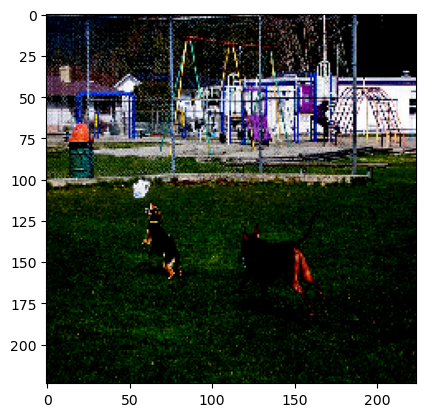

In [357]:
import matplotlib.pyplot as plt

plt.imshow(test_data_gen[0][0][0][0])
plt.show()

In [358]:
def generate_caption(image_array, tokenizer, en_model, decoder, max_len):
    # 인코더로 이미지 임베딩 추출
    img_embedding = en_model.predict(image_array.reshape(1, 224, 224, 3))

    # 시작 토큰으로 디코더 입력 초기화
    caption = ['<start>']
    for _ in range(max_len):
        seq = tokenizer.texts_to_sequences([caption])[0]
        seq = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=max_len, padding='post')
        
        # 예측
        y_pred = decoder.predict([img_embedding, seq])
        y_pred_id = tf.argmax(y_pred[0, len(caption)-1]).numpy()
        word = tokenizer.index_word.get(y_pred_id, '<unk>')
        if word == '<end>':
            break
        caption.append(word)

    return ' '.join(caption[1:])  # <start> 제외하고 출력

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


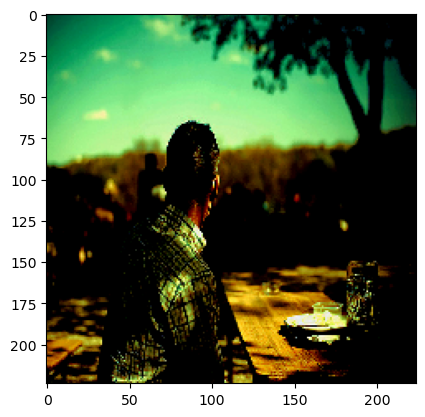

In [365]:
img_ = test_data_gen[0][0][0][0]

plt.imshow(img_)
plt.show()

In [366]:
caption = generate_caption(img_, tokenizer, en_model, decoder, max_len=40)
print("Generated Caption:", caption)

1/1 [==============================] - 0s 24ms/step
Generated Caption: a man in a blue shirt is a a of of of while
